In [1]:
import pandas as pd
import numpy as np
import statistics
import asyncio
from itertools import product
import requests

d:\Programs\anac\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Часть 1 - Анализ исторических данных:


In [2]:
data = pd.read_csv('temperature_data.csv', sep = ',')

In [3]:
data.head(5)

,city,timestamp,temperature,season
0,New York,2010-01-01,4.963029,winter
1,New York,2010-01-02,-0.208866,winter
2,New York,2010-01-03,-0.127266,winter
3,New York,2010-01-04,-6.771845,winter
4,New York,2010-01-05,-3.796650,winter


In [4]:
citys = list(data['city'].unique())
seasons = list(data['season'].unique())

In [5]:
def rolling_mean(data):
    series = pd.Series(data['temperature'])
    window_size = 30
    return series.rolling(window=window_size).mean()

In [6]:
df_mean_rolling=pd.DataFrame()
df_stat=pd.DataFrame(columns=['city','season','mean_t','std_t'])
for c in citys:
    for s in seasons:
        ds = data[(data['city'] == c) & (data['season'] == s)]
        mean_d = rolling_mean(ds) #вычисление скользящего среднего
        df_mean_v = pd.DataFrame()
        df_mean_v['temperature'] = mean_d
        df_mean_v['timestamp'] = ds['timestamp']
        df_mean_v['city'],df_mean_v['season'] = c,s
        
        mean_t = ds['temperature'].mean()  #вычисление среднего
        df_s = pd.DataFrame([[c, s, mean_t, statistics.stdev(ds['temperature'], xbar=mean_t)]], columns=['city','season','mean_t','std_t']) #вычисление стандартного отклонения
        df_stat = pd.concat([df_stat, df_s], ignore_index=True)

    df_mean_rolling = pd.concat([df_mean_rolling, df_mean_v], ignore_index=True) 



C:\Users\DARYA\AppData\Local\Temp\ipykernel_5116\4271556298.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stat = pd.concat([df_stat, df_s], ignore_index=True)


In [7]:
df_stat.head()

,city,season,mean_t,std_t
0,New York,winter,-0.159112,4.915984
1,New York,spring,9.992403,5.161278
2,New York,summer,25.107327,5.005208
3,New York,autumn,15.071570,5.152161
4,London,winter,5.040699,4.978071


In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def anomaly(x): #функция для выявления аномалий
    if type(x['city']) is pd.core.series.Series:
        c = x['city'][0]
    else:
        c = x['city']
    if type(x['city']) is pd.core.series.Series:
        s = x['season'][0]
    else:
        s = x['season']
    stats = df_stat[(df_stat['city'] == c) & (df_stat['season'] == s)]
    a = float(stats['mean_t'] - 2 * stats['std_t'])
    b = float(stats['mean_t'] + 2 * stats['std_t'])
    if x is not np.NaN:
        if type(x['temperature']) is not pd.core.series.Series:
            if (x['temperature'] < a) | (x['temperature'] > b):
                return True
        else:
            if (x['temperature'][0] < a) | (x['temperature'][0] > b):
                return True
    return False

In [9]:
data['anomaly'] = data.apply(lambda x: anomaly(x), axis = 1)

In [10]:
data[data['anomaly'] == True]

,city,timestamp,temperature,season,anomaly
5,New York,2010-01-06,9.937328,winter,True
50,New York,2010-02-20,-11.228213,winter,True
58,New York,2010-02-28,-11.188717,winter,True
77,New York,2010-03-19,-3.217565,spring,True
78,New York,2010-03-20,25.615630,spring,True
...,...,...,...,...,...
54650,Mexico City,2019-09-21,25.442067,autumn,True
54707,Mexico City,2019-11-17,25.992361,autumn,True
54732,Mexico City,2019-12-12,22.568802,winter,True
54734,Mexico City,2019-12-14,23.065431,winter,True


Параллельное вычисление реализовано в файле HW1-3.py. Параллельное вычисление получилось быстрее обычного:

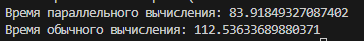

- Подключить OpenWeatherMap API для получения текущей температуры города. Для получения API Key (бесплатно) надо зарегистрироваться на сайте. Обратите внимание, что API Key может активироваться только через 2-3 часа, это нормально. Посему получите ключ заранее.
   - Получить текущую температуру для выбранного города через OpenWeatherMap API.
   - Определить, является ли текущая температура нормальной, исходя из исторических данных для текущего сезона.
   - Данные на самом деле не совсем реальные (сюрпрайз). Поэтому на момент эксперимента погода в Берлине, Каире и Дубае была в рамках нормы, а в Пекине и Москве аномальная. Протестируйте свое решение для разных городов.
   - Попробуйте для получения текущей температуры использовать синхронные и асинхронные методы. Что здесь лучше использовать?

In [11]:
list(data['city'].unique())

['New York',
 'London',
 'Paris',
 'Tokyo',
 'Moscow',
 'Sydney',
 'Berlin',
 'Beijing',
 'Rio de Janeiro',
 'Dubai',
 'Los Angeles',
 'Singapore',
 'Mumbai',
 'Cairo',
 'Mexico City']

In [12]:
API_KEY = ""
CITY = "Москва"

url = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print(f"Погода в {CITY}: {data['main']['temp']}°C")
else:
    print("Ошибка при запросе данных")

Погода в Москва: 0.4°C


In [13]:
if (anomaly(pd.DataFrame([['Moscow', 'winter', data['main']['temp']]], columns = ['city', 'season', 'temperature']))):
    print(f"В городе {CITY} нормальная температура")
else:
    print(f"В городе {CITY} не нормальная температура")

В городе Москва нормальная температура


In [14]:
data

{'coord': {'lon': 37.6156, 'lat': 55.7522},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04d'}],
 'base': 'stations',
 'main': {'temp': 0.4,
  'feels_like': -2.85,
  'temp_min': -0.71,
  'temp_max': 0.77,
  'pressure': 1023,
  'humidity': 66,
  'sea_level': 1023,
  'grnd_level': 1003},
 'visibility': 10000,
 'wind': {'speed': 2.81, 'deg': 215, 'gust': 6.51},
 'clouds': {'all': 90},
 'dt': 1735465473,
 'sys': {'type': 2,
  'id': 2095214,
  'country': 'RU',
  'sunrise': 1735451972,
  'sunset': 1735477412},
 'timezone': 10800,
 'id': 524901,
 'name': 'Moscow',
 'cod': 200}

In [15]:
import time
import random
start_s = time.time()
curr_data=pd.DataFrame()

for city in citys:
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print(f"Погода в {city}: {data['main']['temp']}°C")
    else:
        print("Ошибка при запросе данных")
    curr_data = pd.concat([curr_data, pd.DataFrame([[city, data['main']['temp']]], columns = ['city', 'temperature'])])
    time.sleep(random.randint(2, 12))
    
curr_data['season'] = 'winter'
curr_data['anomaly'] = curr_data.apply(lambda x: anomaly(x), axis = 1)
sync_time = time.time() - start_s

Погода в New York: 7.91°C
Погода в London: 3.94°C
Погода в Paris: 2.65°C
Погода в Tokyo: 7.78°C
Погода в Moscow: 0.44°C
Погода в Sydney: 21.97°C
Погода в Berlin: 1.03°C
Погода в Beijing: 0.94°C
Погода в Rio de Janeiro: 22.87°C
Погода в Dubai: 25.96°C
Погода в Los Angeles: 10.84°C
Погода в Singapore: 26.04°C
Погода в Mumbai: 30.99°C
Погода в Cairo: 17.42°C
Погода в Mexico City: 11.17°C


In [16]:
#Города с выявленными аномалиями 
curr_data[curr_data['anomaly']]

,city,temperature,season,anomaly
0,Moscow,0.44,winter,True
0,Sydney,21.97,winter,True


In [17]:
#Города с нормальной температурой 
curr_data[curr_data['anomaly'] == False]

,city,temperature,season,anomaly
0,New York,7.91,winter,False
0,London,3.94,winter,False
0,Paris,2.65,winter,False
0,Tokyo,7.78,winter,False
0,Berlin,1.03,winter,False
0,Beijing,0.94,winter,False
0,Rio de Janeiro,22.87,winter,False
0,Dubai,25.96,winter,False
0,Los Angeles,10.84,winter,False
0,Singapore,26.04,winter,False


In [18]:
import aiohttp

lock = asyncio.Lock()

async def get_temp_with_analyse(city):

    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    await asyncio.sleep(random.randint(2, 15))
    async with aiohttp.ClientSession() as session:
        response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print(f"Погода в {city}: {data['main']['temp']}°C")
    else:
        print("Ошибка при запросе данных")

    async with lock:
        global curr_data
        curr_data = pd.concat([curr_data, pd.DataFrame([[city, data['main']['temp']]], columns = ['city', 'temperature'])])
        curr_data['season'] = 'winter'
        curr_data['anomaly'] = curr_data.apply(lambda x: anomaly(x), axis = 1)


async def main():
    queue = asyncio.Queue()

    tasks = [asyncio.create_task(get_temp_with_analyse(city)) for city in citys]

    await asyncio.gather(*tasks)
    await queue.join()


In [19]:
time_s = time.time()
await main()
time_async = time.time() - time_s

Погода в Moscow: 0.44°C
Погода в Beijing: 0.94°C
Погода в Rio de Janeiro: 22.87°C
Погода в Dubai: 25.96°C
Погода в Paris: 2.65°C
Погода в Berlin: 0.8°C
Погода в Mumbai: 30.99°C
Погода в London: 3.86°C
Погода в Cairo: 17.42°C
Погода в New York: 7.91°C
Погода в Los Angeles: 10.84°C
Погода в Sydney: 21.97°C
Погода в Tokyo: 7.78°C
Погода в Mexico City: 11.17°C
Погода в Singapore: 26.04°C


In [20]:
curr_data

,city,temperature,season,anomaly
0,New York,7.91,winter,False
0,London,3.94,winter,False
0,Paris,2.65,winter,False
0,Tokyo,7.78,winter,False
0,Moscow,0.44,winter,True
0,Sydney,21.97,winter,True
0,Berlin,1.03,winter,False
0,Beijing,0.94,winter,False
0,Rio de Janeiro,22.87,winter,False
0,Dubai,25.96,winter,False


In [21]:
print(f'Время параллельного вычисления: {time_async}')
print(f'Время обычного вычисления: {sync_time}')

Время параллельного вычисления: 14.25502347946167
Время обычного вычисления: 126.99702072143555


Время асинхронного выполнения кода (запрос API и определение аномалии) получилось быстрее синхронного.